In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")

import tdgl
import superscreen as sc
from meshpy import triangle

In [2]:
layer = tdgl.Layer(
    coherence_length=1, london_lambda=5, thickness=0.1, z0=0,
)

ro = 5
ri = 2

film = tdgl.Polygon("film", points=sc.geometry.box(2 * ro, points_per_side=101))
hole = tdgl.Polygon("hole", points=sc.geometry.circle(ri, points=401))
source = tdgl.Polygon(points=tdgl.geometry.box(0.1, 10, center=(-ro, 0)))
drain = source.scale(xfact=-1, yfact=0.2)

In [23]:
device = tdgl.Device(
    "box",
    layer=layer,
    film=film,
    holes=[hole],
    #source_terminal=source.rotate(90).scale(xfact=1),
    #drain_terminal=drain.rotate(90),
    length_units="um",
)

In [24]:
device.make_mesh(min_points=2000, optimesh_steps=10)

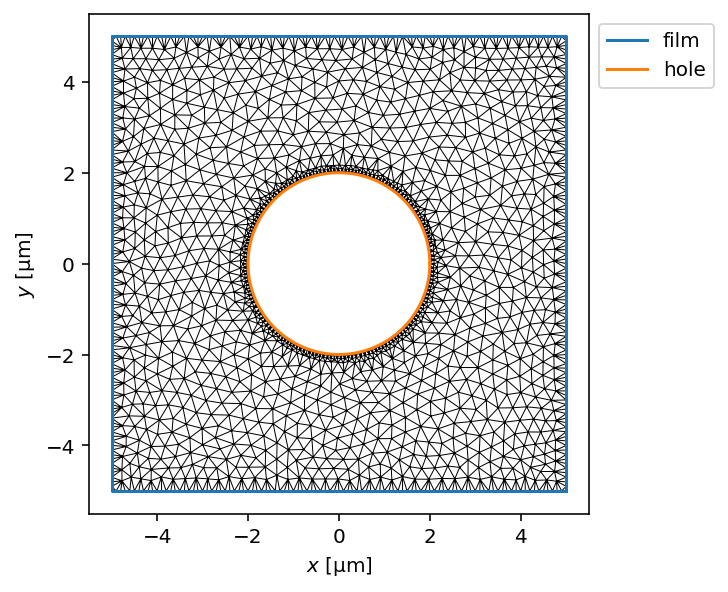

In [25]:
_ = device.plot(mesh=True)

In [26]:
device.polygons

(Polygon(name="film", points=<ndarray: shape=(404, 2)>, mesh=True),
 Polygon(name="hole", points=<ndarray: shape=(402, 2)>, mesh=True))

In [7]:
from tdgl.em import uniform_Bz_vector_potential

ureg = device.ureg

def applied_potential(x, y, z, field="1 uT"):
    length_units = ureg(device.length_units)
    positions = (
        np.stack([x, y, z], axis=1) * length_units
    ).to("m")
    potential = uniform_Bz_vector_potential(positions, field)
    return potential.to(f"mT * {device.length_units}").m

In [8]:
vector_potential = tdgl.Parameter(applied_potential, field="1 uT")

In [9]:
from tdgl.solve import solve

In [10]:
def pinning_sites(xy) -> bool:
    return np.linalg.norm(xy) > 4


solution = solve(
    device,
    vector_potential,
    "output2.h5",
    rtol=0,
    pinning_sites=0,
    field_units="mT",
    gamma=10,
    dt=1e-3,
    skip=0,
    max_steps=10_000,
    save_every=100,
    source_drain_current=0,
    include_screening=False,
)

Simulating: 100%|██████████| 10001/10001 [00:18<00:00, 549.19it/s]


In [29]:
[hole.copy() for hole in device.holes]

[Polygon(name="hole", points=<ndarray: shape=(402, 2)>, mesh=True)]

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'$|\\,\\vec{J}\\,|$'}, xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>)

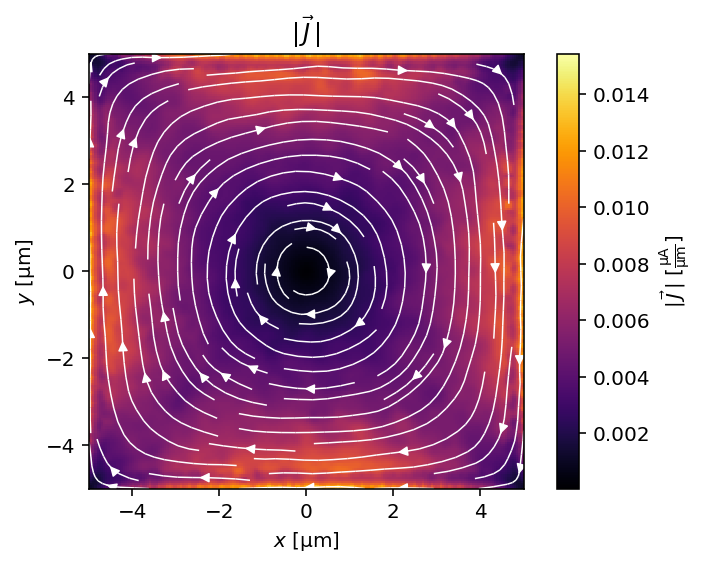

In [11]:
solution.plot_currents()

In [12]:
from tdgl.solution import Solution

In [13]:
s = Solution.from_hdf5(solution.path)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'$\\vec{\\omega}=\\vec{\\nabla}\\times\\vec{J}$'}, xlabel='$x$ [$\\mathrm{µm}$]', ylabel='$y$ [$\\mathrm{µm}$]'>)

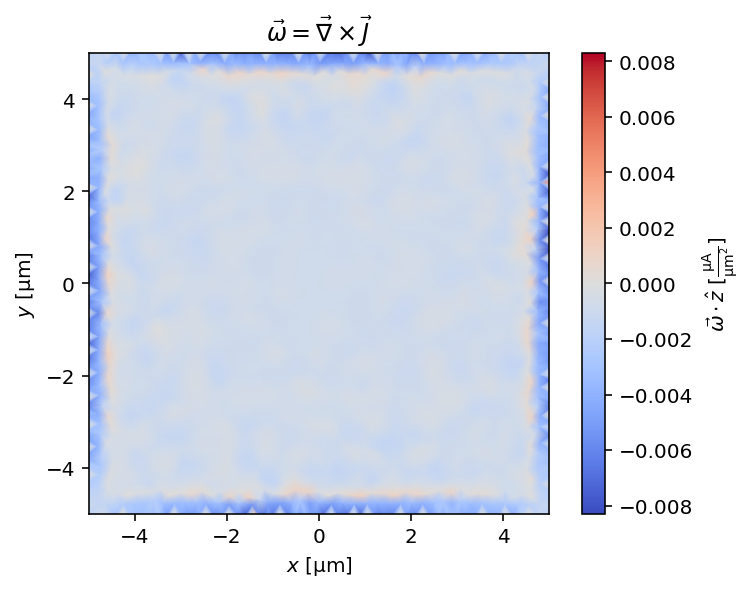

In [20]:
s.plot_vorticity()

In [17]:
f = solution.polygon_fluxoid(sc.geometry.circle(1, center=(2, -2)))

In [18]:
f

Fluxoid(flux_part=<Quantity(0.00148878013, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(-0.00142870158, 'magnetic_flux_quantum')>)

In [19]:
f.flux_part / f.supercurrent_part

-1.0420511501628504 <Unit('dimensionless')>

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
xi = device.coherence_length
x = device.mesh.edge_mesh.x * xi
y = device.mesh.edge_mesh.y * xi
im = ax.tripcolor(x, y, solution.vorticity)
cbar = fig.colorbar(im, ax=ax)

In [ ]:
xs = np.linspace(-ro, ro, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.stack([xs, 0 * xs], axis=1),  # horizontal cross-section
    np.stack([xs, -2 * np.ones_like(xs)], axis=1),  # horizontal cross-section
    np.stack([0 * xs, xs], axis=1),  # vertical cross-section
]

fig, ax = solution.plot_currents(
    figsize=(4, 6),
#     dataset="normal_current",
    cross_section_coords=cross_section_coords[:1]
)
ax.set_facecolor("k")

In [ ]:
# fig, ax = solution.plot_field_at_positions(
#     device.points,
#     units="uT",
#     zs=0.05,
#     cross_section_coords=cross_section_coords[:1],
#     figsize=(4, 6),
# )

In [ ]:
f = solution.polygon_fluxoid(sc.geometry.circle(ri * 2))

In [ ]:
f

In [ ]:
sum(f)

In [ ]:
ureg = device.ureg

In [ ]:
(ureg("100 uT") * np.pi * ureg("2 um")**2).to("Phi_0")

In [ ]:
sum(solution.polygon_fluxoid(sc.geometry.circle(2.5)))

In [ ]:
sum(solution.polygon_fluxoid(sc.geometry.circle(3)))

In [ ]:
xgrid, ygrid, Jgrid = solution.grid_current_density()

In [ ]:
Jgrid.shape

In [ ]:
xy = np.stack([xgrid.ravel(), ygrid.ravel()], axis=1)
Jx = Jgrid[0]

hole_mask = np.logical_or.reduce(
    [hole.contains_points(xy) for hole in device.holes.values()]
)

In [ ]:
ix = np.unravel_index(np.arange(xy.shape[0], dtype=int), Jx.shape)

In [ ]:
Jx

In [ ]:
ureg = device.ureg

In [ ]:
e = ureg("e")
m = ureg("electron_mass")
xi = ureg("100 nm")
Phi_0 = ureg("Phi_0")
mu_0 = ureg("mu_0")

In [ ]:
(e**2/m * Phi_0 / xi).to_base_units()

In [ ]:
(e**2 / m * ureg("tesla * meter")).to_base_units()

In [ ]:
(xi * m / e**2 / Phi_0).to_base_units()

In [ ]:
np.random.default_rng().choice(np.arange(10), size=0, replace=False)

In [ ]:
ureg("0.275 Phi_0").to("mT * um**2")